# Model Building 

## Data Pipeline
Tensorflow works best when data is organized into an input pipeline.  These pipelines help organize, batch, shuffle, and serve your data to CPU/GPU during learning.   The [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) module API assists with this.  

The main structure is the `tf.data.Dataset` object.  It loads data from disk, applies optimized transformations, creates batches, and sends it to CPU/GPU.  

[Google blog post on tf.data.Datasets](https://developers.googleblog.com/2017/09/introducing-tensorflow-datasets.html)   
[Tutorial on tf.data](https://www.tensorflow.org/guide/data)   
[Advanced guide on tf.data](https://www.tensorflow.org/guide/data)   

--- 


In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers 

from PIL import Image 

print(tf.__version__)

2.1.0


### Read X, y from files 
Preprocessing is done in `munge-data.ipynb`

In [2]:
y_train_bin = np.loadtxt('data/munged/y_train.csv', delimiter=',') 
y_val_bin = np.loadtxt('data/munged/y_val.csv', delimiter=',') 
y_test_bin = np.loadtxt('data/munged/y_test.csv', delimiter=',') 

In [3]:
X_train = np.loadtxt('data/munged/X_train.csv', dtype=str)
X_val = np.loadtxt('data/munged/X_val.csv', dtype=str)
X_test = np.loadtxt('data/munged/X_test.csv', dtype=str)

Verify data shapes 

In [4]:
y_train_bin.shape, y_val_bin.shape, y_test_bin.shape

((691, 18), (77, 18), (41, 18))

In [5]:
len(X_train), len(X_val), len(X_test)

(691, 77, 41)

Read labels from file 

In [6]:
import json 

with open('data/munged/labels.json') as json_file:
    type_encoding = json.load(json_file)

# convert string keys to ints 
type_encoding = {int(k):v for k, v in type_encoding.items()}

type_encoding

{0: 'Bug',
 1: 'Dark',
 2: 'Dragon',
 3: 'Electric',
 4: 'Fairy',
 5: 'Fighting',
 6: 'Fire',
 7: 'Flying',
 8: 'Ghost',
 9: 'Grass',
 10: 'Ground',
 11: 'Ice',
 12: 'Normal',
 13: 'Poison',
 14: 'Psychic',
 15: 'Rock',
 16: 'Steel',
 17: 'Water'}

### Build Pipeline 

We are ready to build the tf.data.Dataset.  In these functions, you _must_ use tf API and operate with tensor objects.  

In [7]:
from importlib import reload 
import utils 

In [8]:
BATCH_SIZE = 32 
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 8    # Shuffle the training data by a chunck of 8 observations

In [9]:
train_ds = utils.create_dataset(X_train, y_train_bin, SHUFFLE_BUFFER_SIZE, AUTOTUNE, BATCH_SIZE)
val_ds = utils.create_dataset(X_val, y_val_bin, SHUFFLE_BUFFER_SIZE, AUTOTUNE, BATCH_SIZE)
test_ds = utils.create_dataset(X_test, y_test_bin, SHUFFLE_BUFFER_SIZE, AUTOTUNE, BATCH_SIZE)

## Examine the `tf.data.Dataset`

Shapes of items in dataset: 
```
features:  (BATCH SIZE, IMG_HEIGHT, IMG_WIDTH, CHANNELS)    
label:     (BATCH_SIZE, N_LABELS)

```

Shape of features array: (32, 120, 120, 3)
Shape of labels array: (32, 18)

Plot one of the images from the first batch


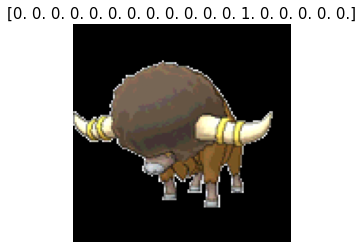

In [10]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)
    
    print("\nPlot one of the images from the first batch")
    plt.imshow(f[0])
    plt.title(str(l.numpy()[0]), size=15)
    plt.axis(False)

Use .take(n) to gave `n` batches.  We set batch_size to 32.  

---
---
# Model Building 



In [11]:
img = Image.open('data/bulbasaur.png')
IMG_HEIGHT, IMG_WIDTH = img.height, img.width
CHANNELS = 3  
N_LABELS = 18

In [22]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten  

model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)), 
    MaxPooling2D((2, 2)), 
    
    Conv2D(64, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)), 
    
    Conv2D(128, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)), 

    Flatten(), 
    Dense(64, activation='relu'), 
    Dense(N_LABELS), 
])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 118, 118, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 57, 57, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)            

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=10, verbose=0
)

callbacks = [early_stopping]

### Train model 

In [26]:
history = model.fit(train_ds, 
                   epochs=500, 
                   validation_data=val_ds, 
                   callbacks=callbacks, 
                   verbose=1)

Train for 22 steps, validate for 3 steps
Epoch 1/500
22/22 [==============================] - 1s 43ms/step - loss: 0.6713 - top_k_categorical_accuracy: 0.1201 - val_loss: 0.6471 - val_top_k_categorical_accuracy: 0.0779
Epoch 2/500
22/22 [==============================] - 0s 19ms/step - loss: 0.6136 - top_k_categorical_accuracy: 0.1505 - val_loss: 0.5882 - val_top_k_categorical_accuracy: 0.0779
Epoch 3/500
22/22 [==============================] - 0s 18ms/step - loss: 0.5493 - top_k_categorical_accuracy: 0.1317 - val_loss: 0.5241 - val_top_k_categorical_accuracy: 0.0779
Epoch 4/500
22/22 [==============================] - 0s 19ms/step - loss: 0.4827 - top_k_categorical_accuracy: 0.1158 - val_loss: 0.4656 - val_top_k_categorical_accuracy: 0.0649
Epoch 5/500
22/22 [==============================] - 0s 19ms/step - loss: 0.4213 - top_k_categorical_accuracy: 0.1071 - val_loss: 0.4113 - val_top_k_categorical_accuracy: 0.0390
Epoch 6/500
22/22 [==============================] - 0s 19ms/step - l

22/22 [==============================] - 0s 20ms/step - loss: 0.2563 - top_k_categorical_accuracy: 0.3155 - val_loss: 0.2763 - val_top_k_categorical_accuracy: 0.2857
Epoch 47/500
22/22 [==============================] - 0s 19ms/step - loss: 0.2556 - top_k_categorical_accuracy: 0.3227 - val_loss: 0.2746 - val_top_k_categorical_accuracy: 0.2727
Epoch 48/500
22/22 [==============================] - 0s 19ms/step - loss: 0.2551 - top_k_categorical_accuracy: 0.3285 - val_loss: 0.2740 - val_top_k_categorical_accuracy: 0.2857
Epoch 49/500
22/22 [==============================] - 0s 20ms/step - loss: 0.2541 - top_k_categorical_accuracy: 0.3169 - val_loss: 0.2756 - val_top_k_categorical_accuracy: 0.2987
Epoch 50/500
22/22 [==============================] - 0s 20ms/step - loss: 0.2536 - top_k_categorical_accuracy: 0.3213 - val_loss: 0.2730 - val_top_k_categorical_accuracy: 0.3117
Epoch 51/500
22/22 [==============================] - 0s 19ms/step - loss: 0.2528 - top_k_categorical_accuracy: 0.3198

### Plot the learning curves 

2/2 - 0s - loss: 0.2667 - top_k_categorical_accuracy: 0.1463


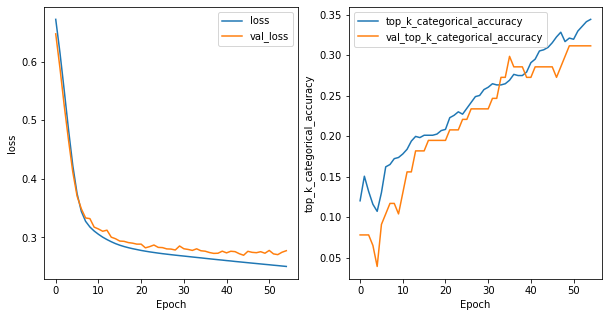

In [31]:
keys = list(history.history.keys())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes.reshape(-1, 1)


for idx, ax in enumerate(axes): 

    axes[idx].plot(history.history[keys[idx]], label=keys[idx])
    axes[idx].plot(history.history["val_" + keys[idx]], label = "val_" + keys[idx])
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel(keys[idx])
    axes[idx].legend()

test_loss, test_acc = model.evaluate(test_ds, verbose=2)

## Visualize results 

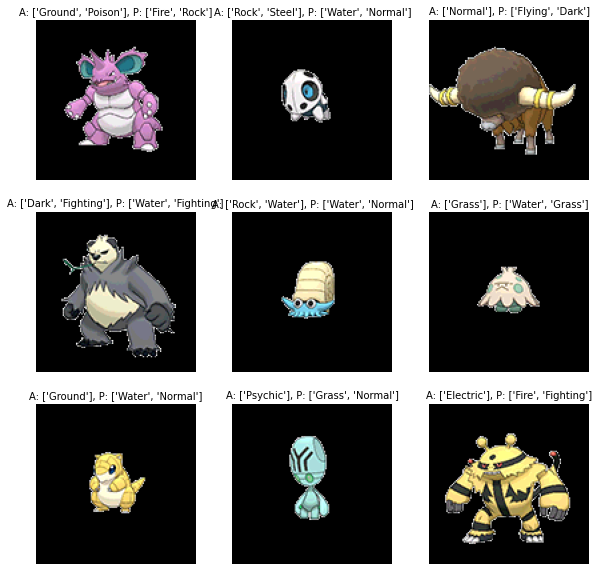

In [28]:
# Training data 
utils.plot_prediction_grid(model, train_ds, True)

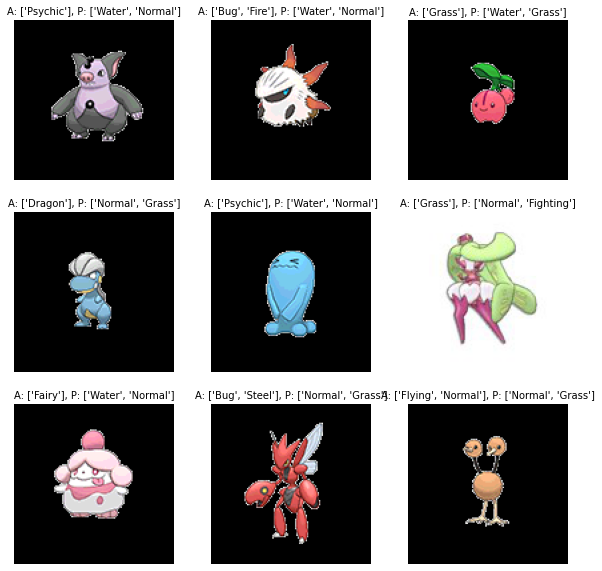

In [29]:
## Test on test_set 
utils.plot_prediction_grid(model, test_ds, True)

---
---
---

## Save model 

In [20]:
# from datetime import datetime
# import os 

# date_time = datetime.now().strftime("%Y%m%d-%H%M%S")
# dirname = "saved_models/" + date_time + "-baseline"

# os.mkdir(dirname)
# model.save(dirname)

### load model and test 

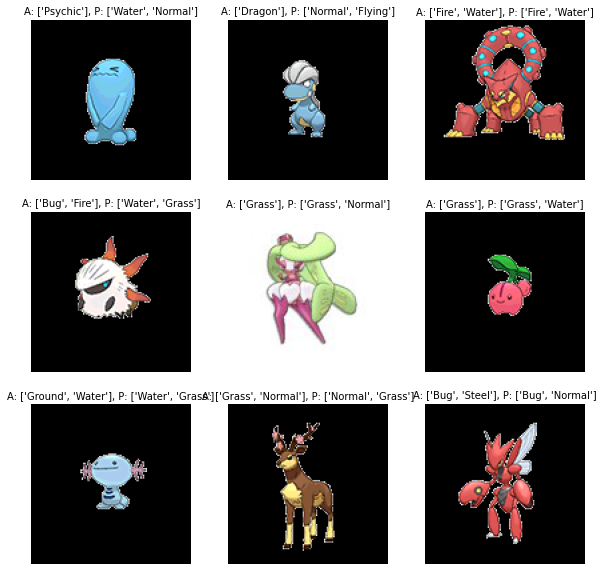

In [30]:
new_model = tf.keras.models.load_model('saved_models/20200627-133409-baseline')

## Test on test_set 
utils.plot_prediction_grid(new_model, test_ds, True)